Welcome to my Neural Network (NN) for predicting small molecule toxicity!

First thing's first, I do not recommend testing the models predictive capacity by eating one or more of the molecules it says are safe

Second thing's second, as an MD course you're not expected to understand everything I'm writing down here. I'll put a number in brackets (eg. [1]) to indicate some of these things, and I'll have a little markdown index at the bottom where I cover each of those things in more detail if you're interested in learning more!




This project is meant to be an example code for a Molecular Dynamics class at UCONN for a simple Convolutional Neural Network (CNN, [0]) that predicts small molecule toxicity as a way of breifly introducing ML, so I'm not going to dig too deep into the weeds of how this works here. The dataset is awesome, it's the ToxCast dataset from moleculenet.org, and it consists of 617 different assay results for almost 8600 small molecules (in the form of SMILES([1]) strings). 

So here we'll go through the different parts of setting up an ML model with the help of pandas and numpy, and then we'll train on the dataset for different hyperparameters and see how well it learns! The current version has an F1 score of ~.834, which I'll discuss more when we get there but for data that's as skewed as we'll see this is, it's a better metric than general accuracy for how well the model is performing.


Regardless, enjoy running through, it should be fairly straightforward to follow and there are graphs and outputs to indicate how things are going! 

"I can't promise it won't poision you, but I can promise that if it does it'll look good doing it!"


In [1]:
#importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow.keras.callbacks as callbacks
from tensorflow.keras.regularizers import l2
from sklearn.metrics import hamming_loss, f1_score







Okay so after importing all those modules (if you couldn't tell we're using tensorflow[2]), it's time to load and sort out the toxcast data.

We'll pull it out as a pandas dataframe, setting labels equal to the molecules undergoing testing. The dataset isn't complete because not all molecules underwent all tets, so a 0 is put in the place of missing values
    I recognize this isn't the best way to handle missing data generally, don't assume a mushroom is edible because nobody's eaten it before.

From there we turn the pandas datasets into numpy arrays, which I'm much more of a fan of. It's always good to visualize your data (thanks Andrew Ng!), so I've also included here the shape of matrix y, so it's clear here that the 0th dimension holds our molecules and the 1st holds our assays (dimensions in numpy start indexing at 0 so the dimensions printed will be Dim-1).

We also have a "smiles" vector that contains the molecule SMILES string. This should be the same length 




, which should contain all the 617 different toxicology assays for all 8598 molecules, as well as the shape of the smiles variable containing the smiles string for all of that data, and I've printed out the first 2 items in the smiles vector to double-check.

Then, of course, there's the graph, which just shows the difference between the counts of 0s and 1s in the data, with 1s being an order of magnitude lower than 0s. This isn't super important until we squash all the toxic data into one single vector instead of this matrix of the different types of toxic, so we'll look at another later.

In [2]:
## # Loading toxcast data (pandas df)
toxcast_df = pd.read_csv('toxcast_data.csv')
# Selecting relevant columns (all labels excluding SMILES)
labels = toxcast_df.columns[1:].tolist()
# Filling missing values with 0 and making them integers
toxcast_df[labels] = toxcast_df[labels].fillna(0).astype(int)

# Convert to numpy arrays
smiles = toxcast_df['smiles'].values
y = toxcast_df[labels].values

for i, length in enumerate(smiles.shape):
    print(f"Length of dimension {i}: {length}")

#checking out our new arrays
print(f"y shape is {y.shape}")
print(f"total size: {y.size}")

Length of dimension 0: 8597
y shape is (8597, 617)
total size: 5304349


We also have a "smiles" vector that contains the molecule SMILES string. This should be the same length as the 0th dimension of our array y, which indicates a match between the molecule and it's results. We can see that by printing the shape of smiles. We're also printing the first two smiles strings so you can see what they look like.

In [3]:
#print(y[0:10], 0)
print(f"smiles shae is:{smiles.shape}")
print(smiles[0:2], 0)

smiles shae is:(8597,)
['[O-][N+](=O)C1=CC=C(Cl)C=C1' 'C[SiH](C)O[Si](C)(C)O[Si](C)(C)O[SiH](C)C'] 0


Next let's make a graph of the relative numbers of 0s and 1s in the dataset. in this dataset a 0 indicates that a molecule either passed a particular test or didn't undergo a particular test, and a 1 indicates that a molecule was cytotoxic in that test.

I want to make clear here that this graph isn't terribly important beyond being a cool comparison to a later graph. This is because, to simplify the model, we're taking any molecule that was cytotoxic in any assay as being toxic, so we'll be making a separate matrix that's a lot smaller and easier to quickly train on.

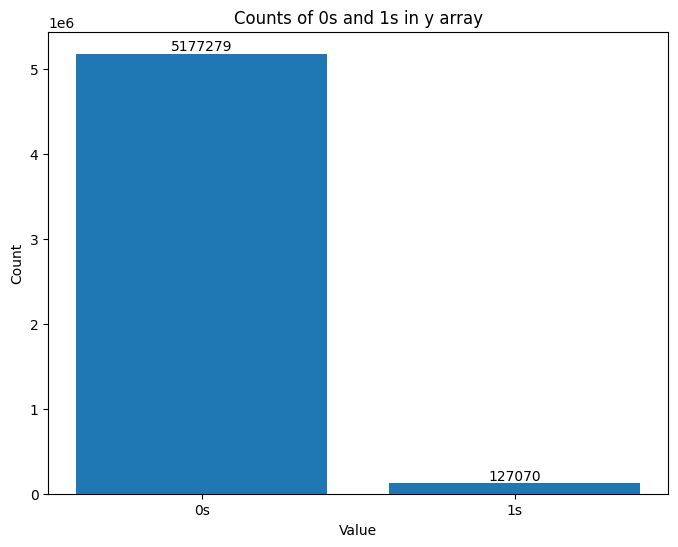

In [4]:
#Take a look at the difference in quantity of 0 and 1. There's a full order of magnitude difference
plt.figure(figsize=(8, 6))
counts = [np.sum(y == 0), np.sum(y == 1)]
bars = plt.bar(['0s', '1s'], counts)
plt.title('Counts of 0s and 1s in y array')
plt.xlabel('Value')
plt.ylabel('Count')
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height(), count, 
             ha='center', va='bottom', fontsize=10)
plt.show()

Now let's take a look at how those counts have changed after creating a vector that is positive if any item in the corresponding array is positivve (if it's toxic to anything it's toxic to everything in this model). This is going to be the equivalent of the y_overall_toxicity vector.

(8597,)


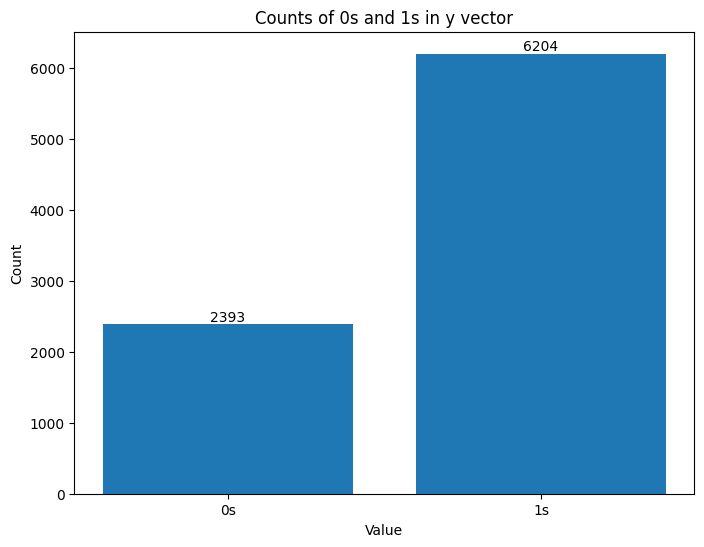

In [5]:
y_overall_toxicity = (y.sum(axis=1) > 0).astype(int)
print(y_overall_toxicity.shape)

plt.figure(figsize=(8, 6))
counts = [np.sum(y_overall_toxicity == 0), np.sum(y_overall_toxicity == 1)]
bars = plt.bar(['0s', '1s'], counts)
plt.title('Counts of 0s and 1s in y vector')
plt.xlabel('Value')
plt.ylabel('Count')
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height(), count, 
             ha='center', va='bottom', fontsize=10)
plt.show()

So it's clear that there are ~3x more positive values than negative. This will have real-world implications on our analysis, so don't forget it!

Next up, we want to tokenize([3]) the smiles strings in order to make predictions about them by being able to recognize key components. We also pad([4]) them so they can all be accepted into the neural network properly, otherwise the size difference would cause an error.

In [6]:
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(smiles)
sequences = tokenizer.texts_to_sequences(smiles)
max_seq_length = max(len(seq) for seq in sequences)
X = pad_sequences(sequences, maxlen=max_seq_length, padding='post')


So now we make np arrays out out of our padded smiles vector, now called simply X, and y_overall_toxicity.

In [7]:
X = np.array(X)
#y = np.array(y)
y_overall_toxicity = np.array(y_overall_toxicity)


So we've  made our np arrays, it's noow time to split the training dadta into training, Cross-Validation (CV), and validation test sets.

The general idea behind these three sets is that you can start by training on the training data (obviously), but if the model overfits[3] it'll do very well with the training data but very poorly on any data that wasn't in the training set. We aim to fix this by giving it a test on the CV set first to get a better idea of how it performs on new data, then repeat until we're ready to run on the test set and get a true estimate of the predictive capability of our model.

So here I've printed some values that may seem random at first (especially because of random.randint). Basically we pick a random integer within the size of dimension X 0 and we pull out the SMILES string associated with that value. From there, we take a look at the tokenized version of that particular SMILES string, and then the padded tokenized version. You can see the padded one is larger and a lot heavier on the 0s (statistically, maybe someone someday will randomly catch the big Kahuna). What's happened there is that the tokens are numbers corresponding to the value of that index in the smiles string, with things like 1 representing the C (carbon atom) or 7 representing N (Nitrogen atom), or even 3 representing an open parentheses. All of these numbers make the text input readable by the neural network, it turns it into math for the computer.

So the padded version with all the 0s is basically a way of making sure all molecules that enter the NN are the same size. The NN will learn very quickly that all those 0s at the end aren't useful to it, but it needs them anyway.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y_overall_toxicity, test_size=0.2, random_state=42)

a = np.random.randint(0, 8575)
print(a)
print(smiles[a])
print(f"Sample tokenized SMILES: {sequences[a]}")
print(f"Padded tokenized SMILES: {X[a]}")

4778
C1CC=CCCC=CCCC=C1
Sample tokenized SMILES: [1, 6, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 6]
Padded tokenized SMILES: [1 6 1 1 2 1 1 1 1 2 1 1 1 1 2 1 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Now we get to define our model. This particular one is a 1D CNN defined in the "model" parameter. I'll explain the specifics of what's going on in there at the end of the notebook, but basically we're building a model to train on. We then compile that model, and I'll talk more about that later as well. Basically this code gives us our CNN model that we'll then use to train on our dataset.

In [9]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_length),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.6),
    Dense(1, activation='sigmoid')
])

#callback = callbacks.EarlyStopping(monitor='loss', patience=3)

model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=['accuracy'])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


So we have our model! Now it's time to train it and see how we do! You'll notice that each epoch has a stated accuracy and loss; those are for the test data, not the validation data. Looking at improvements in accuracy in the training data is important because it tells us whether or not our model is complex enough to accurately represent the data. Seeing that value rise indicates that the model is complex enough to at least get a grasp of the data it has in a high-dimensional graph.

The more important accuracies and losses are the val_accuracy and val_loss values, these correspond to the CV sets to see how our model does on new data. I haven't played around too long with the hyperparameters to fine-tune this model, but I'm still able to get a validation accuracy of around 73%, which is fairly impressive for a small neural network training on your laptop. That said, it's not the most important metric

By the way, you may notice the 86/86 under each epoch next to the progress bar, that's the number of total instances in the batch (training + CV). We do 64 training runs from the training dataset (as shown in batch_size below) and then 20% of that for the CV (validation_split)

In [10]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)#, callbacks=[callback])


Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.7172 - loss: 0.6031 - val_accuracy: 0.7173 - val_loss: 0.5812
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7295 - loss: 0.5772 - val_accuracy: 0.7173 - val_loss: 0.5782
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7185 - loss: 0.5746 - val_accuracy: 0.7173 - val_loss: 0.5615
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7367 - loss: 0.5528 - val_accuracy: 0.7180 - val_loss: 0.5593
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7193 - loss: 0.5544 - val_accuracy: 0.7195 - val_loss: 0.5592
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7286 - loss: 0.5404 - val_accuracy: 0.7202 - val_loss: 0.5565
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7325 - loss: 0.5254 - val_accuracy: 0.7188 - val_loss: 0.5567
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7169 - loss: 0.5307 - val_accuracy: 0.7078 - v

The most important metric in our case is the F1 score. As we saw above, our values are skewed so it could theoretically learn to just predict poisonous for all of them and still get a fairly good accuracy. The F1 score allows us to circumvent that by looking at both precision and recall as metrics to validate our model. We won't go into the specifics here, but Precision can be thought of as "of all the instances the model predicted as positive, how many were actually positive?" while recall can be thought of as "Of all the actual positive instances, how many did the model correctly predict as positive?". This score ranges from 0 to 1, and the maximum value I achieved of ~.834 indicates a very good fit for the model. Let's take a look at the F1 score now!

	
 

In [ ]:
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

f1 = f1_score(y_test, y_pred_binary)
print(f'F1 Score: {f1}')

So we have our F1 score! Nice work (unless you botched hyperparameter tuning and got a bad F1 score, in which case welcome to the life!). Let's take a look at how the accuracy and loss change as a function of # of epochs (basically as a function of time). The ideal thing to see here is that the orange lines representing our validation sets are getting higher accuracy and lower loss, but that's not always true your first runthrough. This takes hyperparameter tuning to try to minimize, and may take alteration of your NN model or even inclusion of new models to make the algorithm more complex, there are a variety of things that can be changed. Luckily there are also various optimization strategies for making that work a little less labor-intensive.

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')


So that's it, you've just built and trained your (probably) first NN model! Now let's get into actually testing it! We'll look at accuracy, precision, hamming loss (fraction of incorrect predictions), and of course F1 score. We've already discussed most of these concepts, so I'm just going to cram it all into one section. REMEMBER: this is just a fun little way to introduce yourself to NNs, it's likely that this will not do an awesome job at keeping you from being poisoned so don't be upset if our graph indicates that 5 or more people die. Keep in mind as well that 




In [ ]:
# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

# Predict on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate Hamming Loss
h_loss = hamming_loss(y_test, y_pred_binary)
print(f'Hamming Loss: {h_loss}')

# Calculate F1 Score (Micro and Macro)
f1_micro = f1_score(y_test, y_pred_binary, average='micro')
f1_macro = f1_score(y_test, y_pred_binary, average='macro')
print(f'F1 Score (Micro): {f1_micro}')
print(f'F1 Score (Macro): {f1_macro}')

# Plotting the first few actual vs predicted for visual inspection
start = np.random.randint(0,100)
end = start + 20
print(f"starting value is {start}")
plt.figure(figsize=(12, 6))
plt.plot(y_test[start:end], 'ro', label='Actual')
plt.plot(y_pred_binary[start:end], 'bx', label='Predicted')
plt.title('Actual vs Predicted Labels (20 random samples)')
plt.legend(loc='upper right')
plt.show()